## Second RL-model: Q-learning (TD control problem, Off-Policy)

In [1]:
import numpy as np
import tqdm
from collections import defaultdict
import gymnasium as gym
from gymnasium.envs.registration import register

import reinforcement

**Define our Agent**

In [2]:
class QAgent:
    def __init__(
        self,
        env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, observation: tuple[int, int, bool], env) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[observation]))

    def update(
        self,
        observation: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_observation: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_observation])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[observation][action]
        )

        self.q_values[observation][action] = (
            self.q_values[observation][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

**Main Loop for learning**

In [3]:
def run_q_learning(env, q_agent, n_episodes, **kwargs):
    for episode in tqdm.tqdm(range(n_episodes)):
        observation, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = q_agent.get_action(observation, env)
            next_observation, reward, terminated, truncated, info = env.step(action)

            # update the agent
            q_agent.update(observation, action, reward, terminated, next_observation)

            # update if the environment is done and the current observation
            done = terminated or truncated
            observation = next_observation

        q_agent.decay_epsilon()

**Run Training**

In [4]:
# hyperparameters
n_episodes = 250000
learning_rate = 0.005
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

env = reinforcement.SmartChargingEnv()
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

q_agent = QAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

run_q_learning(env, q_agent, n_episodes)

/home/max/Project_AAA/.venv/lib/python3.10/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_attr('num_envs')` that will search the reminding wrappers.
  logger.warn(
100%|██████████| 250000/250000 [02:20<00:00, 1778.28it/s]


**Plot Results**

Actions:  [2, 2, 2, 3, 2, 3, 3, 3]
Reward:  -1832.1077741035176
Final Battery Level:  40


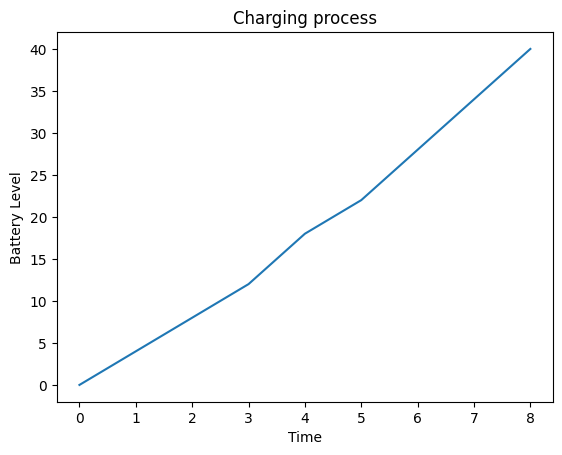

In [5]:
actions, battery_levels, score = reinforcement.run_model(env, q_agent)
print("Actions: ", actions)
print("Reward: ", score)
print("Final Battery Level: ", int(battery_levels[-1]))
reinforcement.plot_model_run(battery_levels)

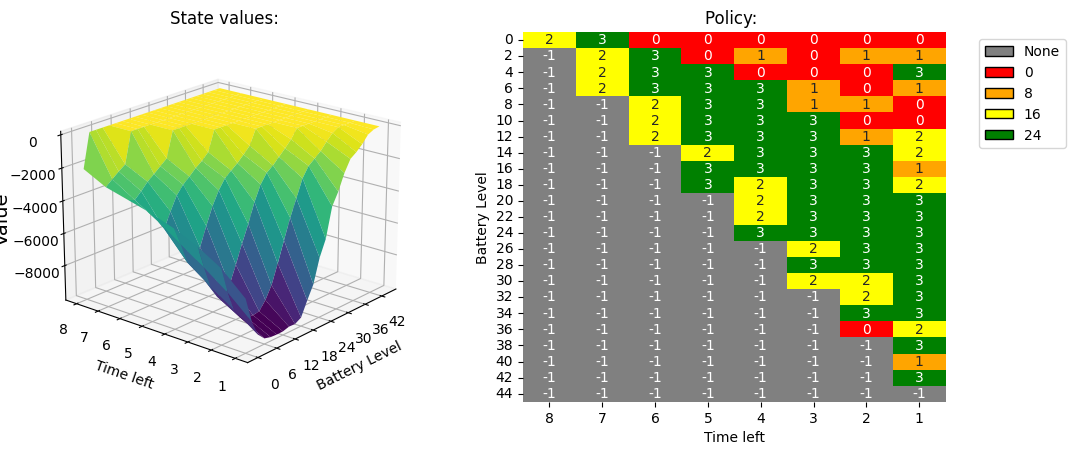

In [6]:
# state values & policy
value_grid, policy_grid = reinforcement.create_grids(q_agent.q_values)
fig1 = reinforcement.create_policy_plots(value_grid, policy_grid)

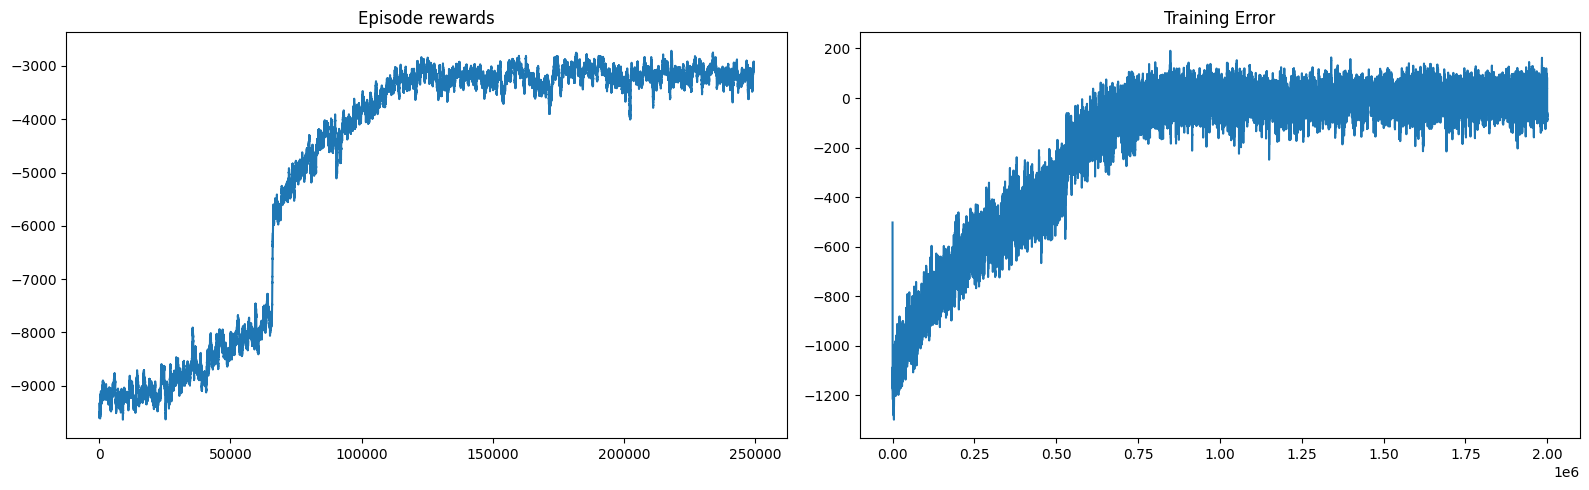

In [7]:
reinforcement.plot_training_performance(env, q_agent)

In [8]:
env.close()

## Second RL-model advanced: Double Q-learning

**Define our Agent**

In [9]:
class DoubleQAgent:
    def __init__(
        self,
        env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        q_values_a = defaultdict(lambda: np.zeros(env.action_space.n))
        q_values_b = defaultdict(lambda: np.zeros(env.action_space.n))
        self.q_values = [q_values_a, q_values_b]

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, observation: tuple[int, int, bool], env) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax((self.q_values[0][observation] + self.q_values[1][observation]) / 2))

    def update(
        self,
        observation: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_observation: tuple[int, int, bool],
    ):
        # chose which q_value to update at random
        q_value_flag = round(np.random.random())
        
        """Updates the Q-value of an action."""
        future_action = (not terminated) * np.argmax(self.q_values[q_value_flag][next_observation])
        temporal_difference = (
            reward + self.discount_factor * self.q_values[q_value_flag - 1][next_observation][future_action] - self.q_values[q_value_flag][observation][action])
        
        self.q_values[q_value_flag][observation][action] = (
            self.q_values[q_value_flag][observation][action] + self.lr * temporal_difference)
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

**Run Training**

In [10]:
# hyperparameters
n_episodes = 500000
learning_rate = 0.005
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

env = reinforcement.SmartChargingEnv()
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

doubleq_agent = DoubleQAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

run_q_learning(env, doubleq_agent, n_episodes)

/home/max/Project_AAA/.venv/lib/python3.10/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_attr('num_envs')` that will search the reminding wrappers.
  logger.warn(
100%|██████████| 500000/500000 [04:31<00:00, 1839.02it/s]


**Plot Results**

Actions:  [2, 2, 2, 3, 3, 3, 2, 3]
Reward:  -1832.1077741035176
Final Battery Level:  40


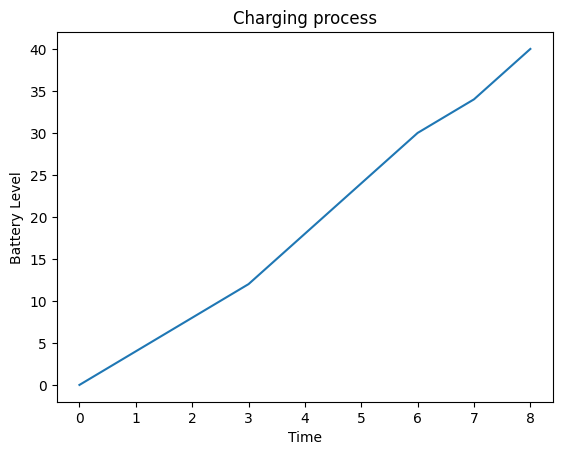

In [11]:
actions, battery_levels, score = reinforcement.run_model(env, doubleq_agent)
print("Actions: ", actions)
print("Reward: ", score)
print("Final Battery Level: ", int(battery_levels[-1]))
reinforcement.plot_model_run(battery_levels)

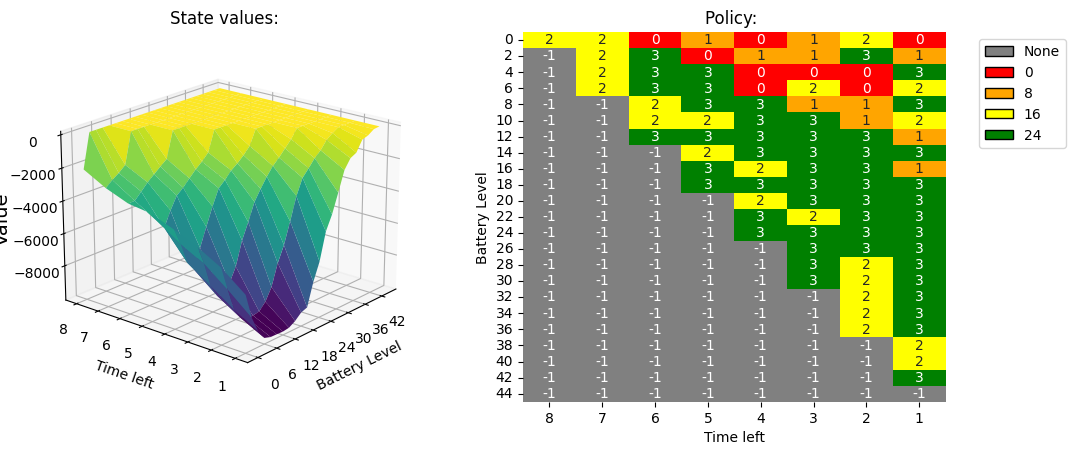

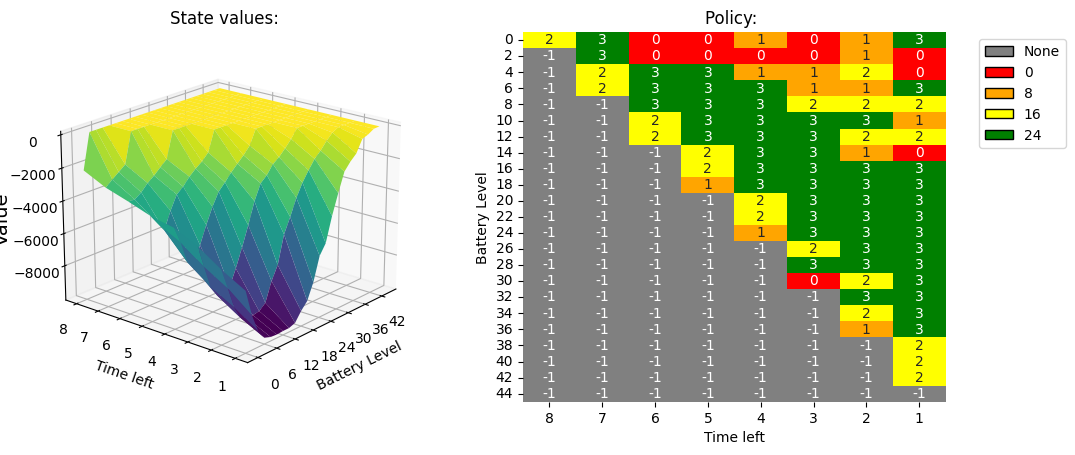

In [12]:
# state values & policy
value_grid, policy_grid = reinforcement.create_grids(doubleq_agent.q_values[0])
fig1 = reinforcement.create_policy_plots(value_grid, policy_grid)

# state values & policy
value_grid, policy_grid = reinforcement.create_grids(doubleq_agent.q_values[1])
fig1 = reinforcement.create_policy_plots(value_grid, policy_grid)

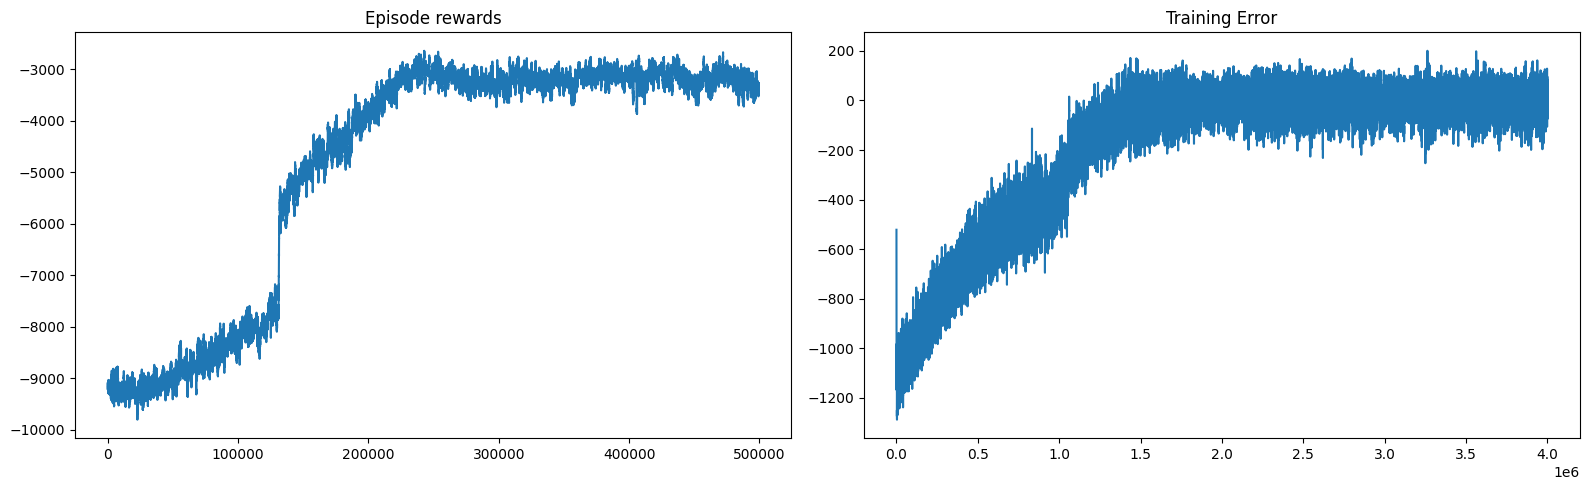

In [13]:
reinforcement.plot_training_performance(env, doubleq_agent)

In [14]:
env.close()